In [1]:
import warnings
warnings.filterwarnings("ignore")

## Build the Model

In [2]:
# import tensorflow as tf
import keras
import numpy as np
import os
import random
import cv2
import math
import seaborn as sns

# print('tensorflow: %s' % tensorflow.__version__)
print('keras: %s' % keras.__version__)

from tensorflow.keras.optimizers import SGD
from keras.layers import Input, concatenate, ZeroPadding2D, InputSpec
from keras.layers import Dense, Dropout, Activation, Layer, Conv2D
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
import keras.backend as K
from sklearn.metrics import log_loss

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split 


keras: 2.6.0


In [3]:
from keras import initializers as initializations

class Scale(Layer):
    '''Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:

        out = in * gamma + beta,

    where 'gamma' and 'beta' are the weights and biases larned.

    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        # Compatibility with TensorFlow >= 1.0.0
        self.gamma = K.variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = K.variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        #self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self._trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## DenseNet121 Model

In [4]:
def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    '''
    DenseNet 121 Model for Keras

    Model Schema is based on 
    https://github.com/flyyufelix/DenseNet-Keras

    # Returns
        A Keras model instance.
    '''

    # Handle Dimension Ordering for different backends
    global concat_axis
    img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    concat_axis = 3


    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,24,16] # For DenseNet-121

    # Initial convolution
    x = Conv2D(nb_filter, (7, 7), strides=(2, 2), name='conv1', use_bias=False)(img_input)
    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, dropout_rate=dropout_rate)
        nb_filter = int(nb_filter)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate)

    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis)(x)
    x = Activation('relu')(x)

    x_fc = GlobalAveragePooling2D()(x)
    x_fc = Dense(1000)(x_fc)
    x_fc = Activation('softmax')(x_fc)

    model = Model(img_input, x_fc)

    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = GlobalAveragePooling2D()(x)
    x_newfc = Dense(num_classes)(x_newfc)
    x_newfc = Activation('softmax')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [5]:
def conv_block(x, stage, branch, nb_filter, dropout_rate=None):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout '''


    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(inter_channel, (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(nb_filter, (3, 3), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block(x, stage, nb_filter, dropout_rate=None):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout  '''


    x = BatchNormalization(axis=concat_axis)(x)
    x = Scale(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_filter), (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate)
        concat_feat = concatenate([concat_feat, x], axis=concat_axis)

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter


## Implement load_data() module

In [6]:
#Define data path
Base_DIR = '/kaggle/input/prostate-classification-ukm/Prostate/'

def load_data():
  data=[]
  labels=[]
  random.seed(42)
  imagePaths = sorted(list(os.listdir(Base_DIR)))
  random.shuffle(imagePaths)
  print(imagePaths)

  for img in imagePaths:
    path=sorted(list(os.listdir(Base_DIR+img)))
    for i in path:
        image = cv2.imread(Base_DIR+img+'/'+i)
        image = cv2.resize(image, (224,224))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)
  data = np.array(data, dtype="float32") / 255.0
  labels = np.array(labels)
  mlb = LabelBinarizer()
  labels = mlb.fit_transform(labels)
  #print(labels[0])

  (xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.25,random_state=42)
  #print(xtrain.shape, xtest.shape)
  return xtrain, ytrain, xtest, ytest

# load_data()

## Predict

In [7]:
from keras.callbacks import ModelCheckpoint
if __name__ == '__main__':

    # Example to fine-tune on 193 samples from UKM

    img_rows, img_cols = 224, 224 # Resolution of inputs
    channel = 3
    num_classes =4
    batch_size = 16 
    nb_epoch = 10

    # Load Prostate data. Please implement your own load_data() module for your own dataset
    X_train, Y_train, X_valid, Y_valid = load_data()
    
    # Load our model
    model = densenet121_model(img_rows=img_rows, img_cols=img_cols, color_type=channel, num_classes=num_classes)
    filepath="bestmodel.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Start Fine-tuning
    history=model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(X_valid, Y_valid),
              callbacks=callbacks_list,
              )

    # Make predictions
    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

    # Cross-entropy loss score
    score = log_loss(Y_valid, predictions_valid)

['G4', 'G3', 'G5', 'Benign']


2023-01-08 03:27:28.042122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 03:27:28.043497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 03:27:28.257768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 03:27:28.259124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 03:27:28.260303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/10


2023-01-08 03:27:53.424123: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 36s 860ms/step - loss: 1.0794 - accuracy: 0.5833 - val_loss: 1.3857 - val_accuracy: 0.2653
Epoch 2/10
9/9 [==============================] - 3s 371ms/step - loss: 0.7040 - accuracy: 0.7431 - val_loss: 1.3911 - val_accuracy: 0.2245
Epoch 3/10
9/9 [==============================] - 3s 365ms/step - loss: 0.5942 - accuracy: 0.7778 - val_loss: 1.4058 - val_accuracy: 0.2245
Epoch 4/10
9/9 [==============================] - 3s 364ms/step - loss: 0.4581 - accuracy: 0.8264 - val_loss: 1.4185 - val_accuracy: 0.2245
Epoch 5/10
9/9 [==============================] - 3s 367ms/step - loss: 0.4065 - accuracy: 0.8542 - val_loss: 1.4405 - val_accuracy: 0.2245
Epoch 6/10
9/9 [==============================] - 3s 366ms/step - loss: 0.3321 - accuracy: 0.8889 - val_loss: 1.4793 - val_accuracy: 0.2245
Epoch 7/10
9/9 [==============================] - 3s 325ms/step - loss: 0.2943 - accuracy: 0.8889 - val_loss: 1.5320 - val_accuracy: 0.2245
Epoch 8/10
9/9 [==============

## Visualize

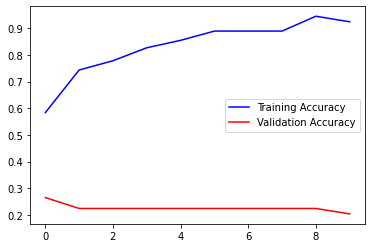

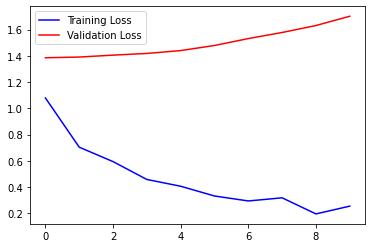

In [8]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
# history.history

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

In [9]:
#X_valid, Y_valid
xtest=X_valid
ytest=Y_valid
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 49 	accurately-predicted-data: 10 	 wrongly-predicted-data:  39
Accuracy: 20.408 %


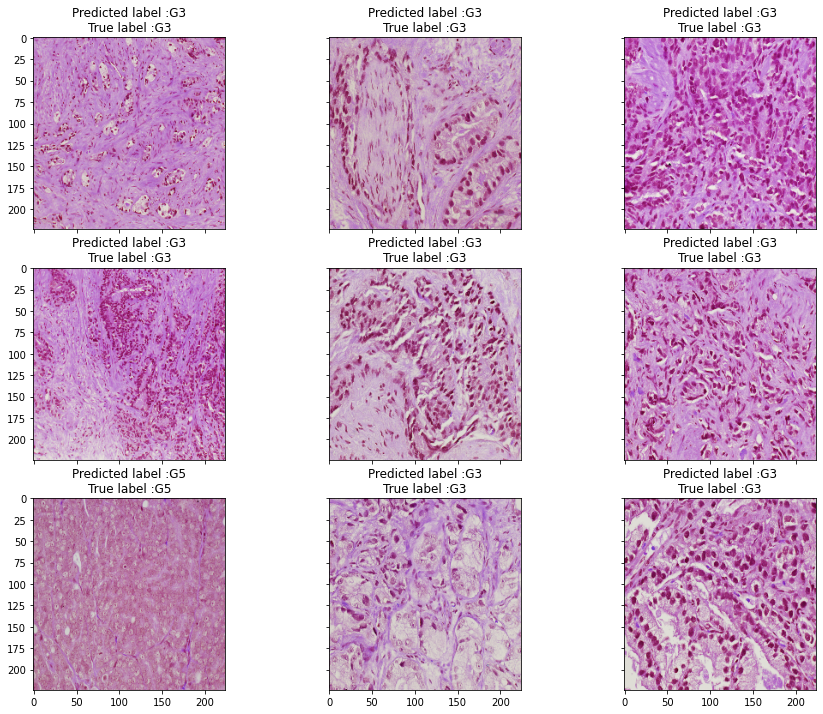

In [10]:
label=['Benign', 'G3','G4','G5']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

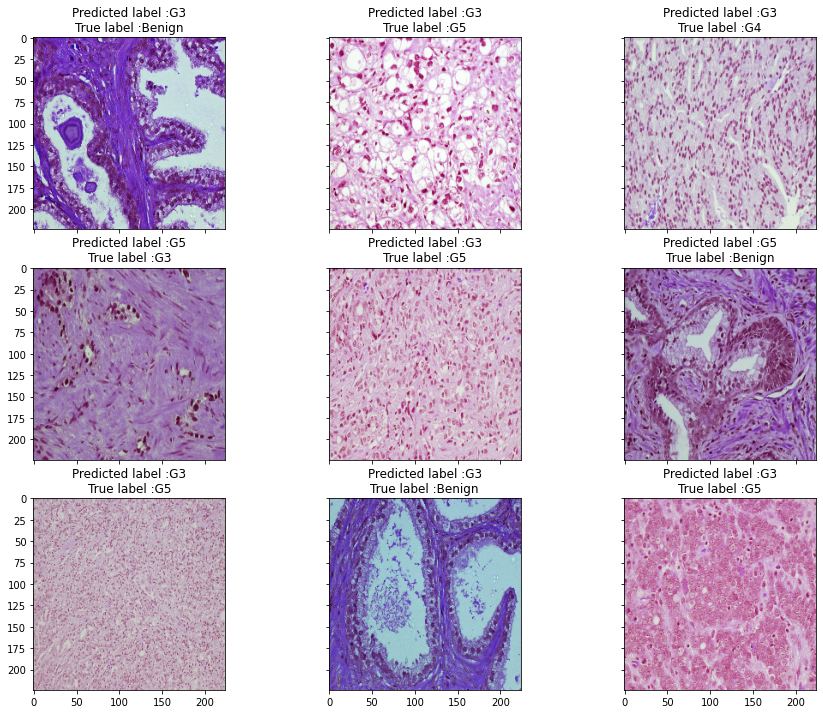

In [11]:
label=['Benign', 'G3','G4','G5']
imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()